In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
from numpy import linalg as LA

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [2]:
file_name = 'joint_[64,64]_[linear,relu]_[20,20]_adjacentTF_noES'

In [3]:
emb = pd.read_csv(f'./emb/{file_name}.csv', index_col=0)

k_emb = emb[emb['type'] == 1].copy(deep=True)
gm_emb = emb[emb['type'] == 2].copy(deep=True)
# gene_emb = emb[emb['type'] == 0].copy(deep=True)

emb.drop('type' , axis='columns', inplace=True)
k_emb.drop('type', axis='columns', inplace=True)
gm_emb.drop('type', axis='columns', inplace=True)
# gene_emb.drop('type', axis='columns', inplace=True)

print(f'K562: {k_emb.shape}')
print(f'GM12878: {gm_emb.shape}')
# print(f'Gene: {gene_emb.shape}')
emb.dtypes

K562: (69, 64)
GM12878: (69, 64)


0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
59    float64
60    float64
61    float64
62    float64
63    float64
Length: 64, dtype: object

## Plot embedding of TFs

In [4]:
tf_emb = pd.concat([gm_emb, k_emb])
all_embeddings = tf_emb.to_numpy()
nodes = tf_emb.index.to_numpy()


In [10]:
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=nodes)
emb_transformed['type'] = emb_transformed.index.map(lambda name: 1 if name[-2:] == '_k' else 2)


-5.324100971221924

In [13]:
emb_transformed.loc['MYC_gm']

0       1.478511
1       3.663211
type    2.000000
Name: MYC_gm, dtype: float64

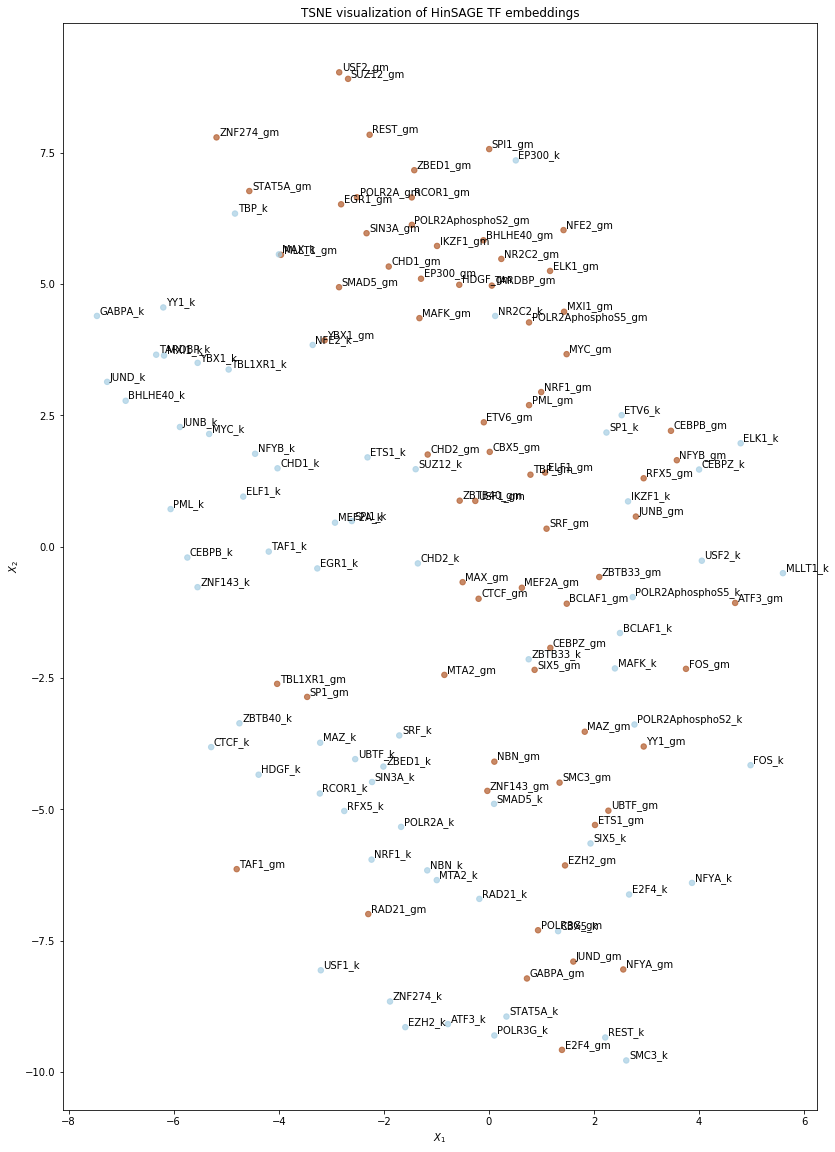

In [11]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
    cmap="Paired",
    alpha=alpha,
    s=30
)
for i, txt in enumerate(nodes):
    ax.annotate(txt, (emb_transformed.iloc[i][0]+.05, emb_transformed.iloc[i][1]+.05))
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE TF embeddings")

# plt.savefig(f'./img/{file_name}_TF.png', dpi=150)
plt.show()

## Calculate embedding distance
1. Traverse all TFs, calculate L2 distance


In [25]:
tf_names = k_emb.index.map(lambda name: name[:-2]).to_list()
k_names = k_emb.index.to_list()
gm_names = gm_emb.index.to_list()

iterables = [list(gm_names), list(k_names)] 
idx = pd.MultiIndex.from_product(iterables, names=['gm', 'k'])

tf_emb_dist = pd.DataFrame(index=idx, columns=['distance'], dtype=np.float32)
tf_emb_dist['gm_emb'] = tf_emb_dist.index.map(lambda x: gm_emb.loc[x[0]])
tf_emb_dist['k_emb'] = tf_emb_dist.index.map(lambda x: k_emb.loc[x[1]])

def get_dist(x):
    return LA.norm(x[0].to_numpy() - x[1].to_numpy())

tf_emb_dist['distance'] = tf_emb_dist[['gm_emb', 'k_emb']].apply(get_dist, axis=1)

tf_emb_dist

distance                                             gm_emb  \
gm      k                                                                       
MAFK_gm FOS_k     0.230988  0     0.000000
1     0.000000
2     0.000000
3...   
        CTCF_k    0.223726  0     0.000000
1     0.000000
2     0.000000
3...   
        ZBTB33_k  0.180720  0     0.000000
1     0.000000
2     0.000000
3...   
        IKZF1_k   0.118472  0     0.000000
1     0.000000
2     0.000000
3...   
        USF1_k    0.234770  0     0.000000
1     0.000000
2     0.000000
3...   
...                    ...                                                ...   
SPI1_gm NBN_k     0.237077  0     0.000000
1     0.000000
2     0.000000
3...   
        TBP_k     0.187411  0     0.000000
1     0.000000
2     0.000000
3...   
        SIN3A_k   0.205230  0     0.000000
1     0.000000
2     0.000000
3...   
        JUND_k    0.194511  0     0.000000
1     0.000000
2     0.000000
3...   
        ZBTB40_k  0.268979  0     0.000000
1     0.000000
2     0.000000
3...   

                                                              k_emb  
gm      k                                                            
MAFK_gm FOS_k     0     0.000000
1     0.000000
2     0.000000
3...  
        CTCF_k    0     0.000000
1     0.000000
2     0.000000
3...  
        ZBTB33_k  0     0.000000
1     0.000000
2     0.000000
3...  
        IKZF1_k   0     0.000000
1     0.000000
2     0.000000
3...  
        USF1_k    0     0.000000
1     0.000000
2     0.000000
3...  
...                                                             ...  
SPI1_gm NBN_k     0     0.000000
1     0.000000
2     0.000000
3...  
        TBP_k     0     0.000000
1     0.000000
2     0.000000
3...  
        SIN3A_k   0     0.000000
1     0.000000
2     0.000000
3...  
        JUND_k    0     0.000000
1     0.000000
2     0.000000
3...  
        ZBTB40_k  0     0.000000
1     0.000000
2     0.000000
3...  

[4761 rows x 3 columns]

We sort the DataFrame according to distance

In [36]:
tf_emb_dist_sorted = tf_emb_dist.sort_values(['gm', 'distance'], ascending=False)
tf_emb_dist_sorted.drop(['gm_emb', 'k_emb'], axis=1, inplace=True)
tf_emb_dist_sorted

distance
gm        k                          
ZNF274_gm SMC3_k             0.657422
          POLR3G_k           0.587022
          REST_k             0.582401
          STAT5A_k           0.528381
          RAD21_k            0.517554
...                               ...
ATF3_gm   POLR2AphosphoS2_k  0.131406
          MLLT1_k            0.129469
          USF2_k             0.107966
          POLR2AphosphoS5_k  0.101934
          IKZF1_k            0.099030

[4761 rows x 1 columns]